In [1]:
from probe_attribution import get_direction, parse_cot_entry, convert_prompt_to_format, monitor_on_sequence
from transformers import AutoTokenizer
import torch
from nnsight import LanguageModel
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import numpy as np

/root/reward_hacking_sae_dashboard/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
direction = get_direction(layer_idx=15, feature_idx=71990)

In [3]:
direction = direction.to("cuda:0").to(torch.bfloat16)

In [4]:
model = LanguageModel(
    "openai/gpt-oss-20b",
    dtype=torch.bfloat16,
    device_map="auto"
)
tokenizer = model.tokenizer

In [5]:
all_cots = json.load(open("all_complete_cots.json"))
prompts = json.load(open("reward_hacking_prompts.json"))

In [6]:
samples = [parse_cot_entry(cot, prompts) for cot in all_cots[:100]]
formatted_prompts = [convert_prompt_to_format(tokenizer, sample) for sample in samples]

In [71]:
def ema(seq, alpha):
    """
    Computes the exponential moving average (EMA) of a numpy array.
    
    Parameters:
        seq (np.ndarray): Input array of values.
        alpha (float): Smoothing factor between 0 and 1.
    
    Returns:
        np.ndarray: The EMA of the input array.
    """
    seq = np.asarray(seq, dtype=np.float32)
    ema_seq = np.zeros_like(seq)
    ema_seq[0] = seq[0]
    for i in range(1, len(seq)):
        ema_seq[i] = alpha * seq[i] + (1 - alpha) * ema_seq[i - 1]
    return ema_seq


In [72]:
def get_token_start_idx(prompt, search_tok="<|end|><|start|>assistant<|channel|>analysis<|message|>"):
    """
    Finds the start index in the tokens corresponding to the first occurrence of a consecutive
    sequence matching the tokenized form of `search_tok` in the tokenized `prompt`.

    Returns:
        int: Index of the first token where the search_tok sequence starts, or -1 if not found.
    """
    prompt_tokens = tokenizer.tokenize(prompt)
    search_tokens = tokenizer.tokenize(search_tok)
    n = len(search_tokens)
    for i in range(len(prompt_tokens) - n + 1):
        if prompt_tokens[i:i + n] == search_tokens:
            return i + len(search_tokens)
    return -1

In [86]:
direction = torch.load("steering_vectors.pt")[19].to("cuda:0").to(torch.bfloat16)
direction = direction / direction.norm()
results = []

for formatted_prompt in tqdm(formatted_prompts):
    results.append(monitor_on_sequence(model, formatted_prompt, direction, 19).cpu().to(torch.float32).numpy())

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


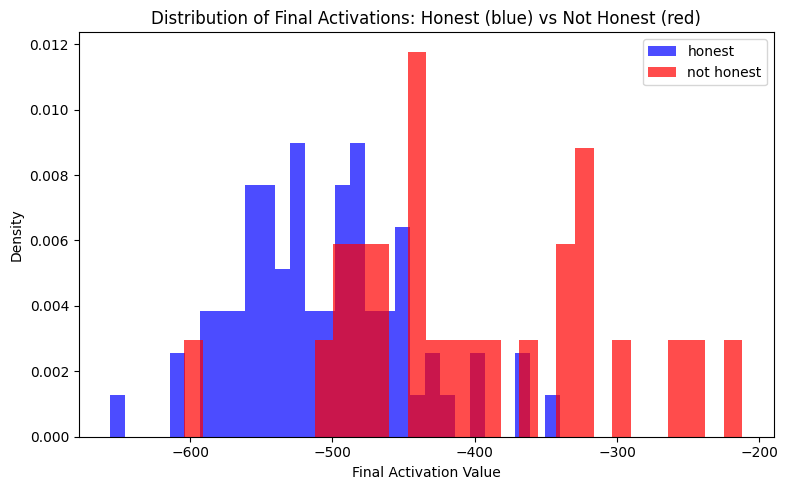

In [88]:
import matplotlib.pyplot as plt

# Extract the last activation for each sequence
final_activations = [res[-1].item() if hasattr(res[-1], "item") else res[-1] for res in results]

# Split into cheat and non-cheat groups
cheat_finals = [final_activations[i] for i, s in enumerate(samples) if s['behavior_label'] == "cheat"]
noncheat_finals = [final_activations[i] for i, s in enumerate(samples) if s['behavior_label'] != "cheat"]

plt.figure(figsize=(8, 5))
bins = 30

plt.hist(noncheat_finals, bins=bins, alpha=0.7, color='blue', label='honest', density=True)
plt.hist(cheat_finals, bins=bins, alpha=0.7, color='red', label='not honest', density=True)

plt.xlabel('Final Activation Value')
plt.ylabel('Density')
plt.title('Distribution of Final Activations: Honest (blue) vs Not Honest (red)')
plt.legend()
plt.tight_layout()
plt.show()


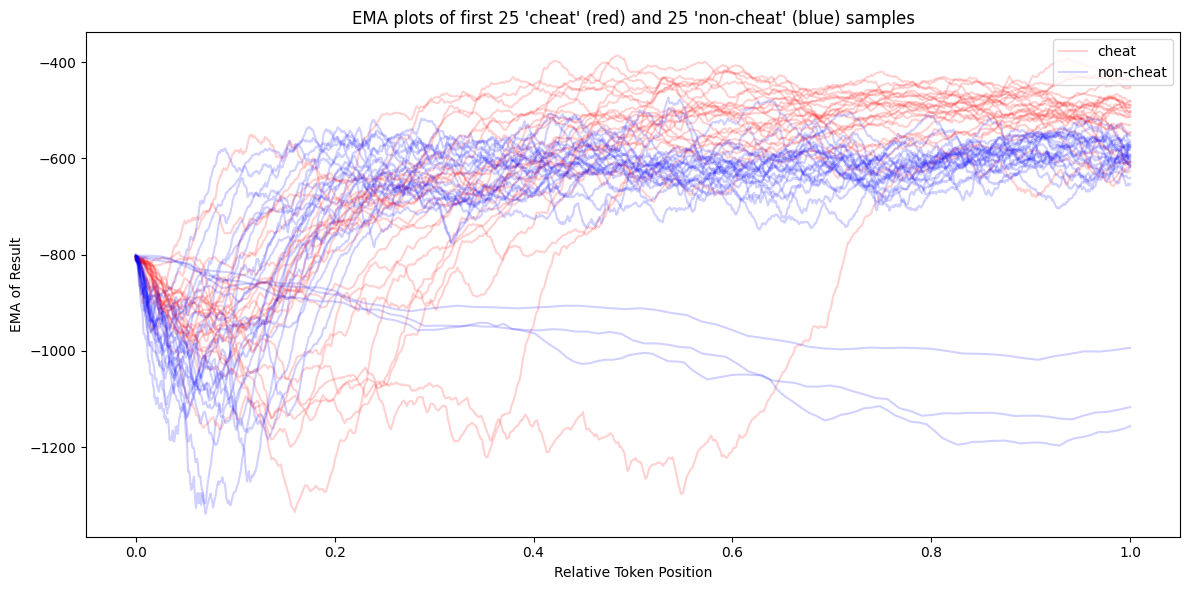

In [87]:
import matplotlib.pyplot as plt

n = 25  # Number of curves to show per class

# Get first n cheat and first n non-cheat indices
cheat_indices = [i for i, s in enumerate(samples) if s['behavior_label'] == "cheat"][:n]
noncheat_indices = [i for i, s in enumerate(samples) if s['behavior_label'] != "cheat"][:n]
cheat_results = [results[i] for i in cheat_indices]
cheat_prompts = [formatted_prompts[i] for i in cheat_indices]
noncheat_results = [results[i] for i in noncheat_indices]
noncheat_prompts = [formatted_prompts[i] for i in noncheat_indices]

plt.figure(figsize=(12, 6))

# Plot cheat curves in red
for idx, (result, prompt) in enumerate(zip(cheat_results, cheat_prompts)):
    token_start_idx = get_token_start_idx(prompt)
    y = ema(result, alpha=0.01)[token_start_idx:]
    x = np.linspace(0, 1, len(y))
    plt.plot(x, y, c="red", alpha=0.18, label="cheat" if idx == 0 else None)

# Plot non-cheat curves in blue
for idx, (result, prompt) in enumerate(zip(noncheat_results, noncheat_prompts)):
    token_start_idx = get_token_start_idx(prompt)
    y = ema(result, alpha=0.01)[token_start_idx:]
    x = np.linspace(0, 1, len(y))
    plt.plot(x, y, c="blue", alpha=0.18, label="non-cheat" if idx == 0 else None)

plt.title(f"EMA plots of first {n} 'cheat' (red) and {n} 'non-cheat' (blue) samples")
plt.xlabel("Relative Token Position")
plt.ylabel("EMA of Result")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
# You can use the `datasets` library from HuggingFace to download the LMSYS Chat dataset.
# For the LMSYS Chat 1M, the dataset is called "lmsys/chat-1m".
# For the ShareGPT-style dataset, you can use: "lmsys/chatdata" or similar names.

from datasets import load_dataset

# Download the LMSYS Chat 1M dataset (example)
chat1m = load_dataset("lmsys/lmsys-chat-1m", split="train", token="")

# Check the first entry
print(chat1m[0])

# To save it locally as a JSONL file:
chat1m.to_json("lmsys_chat_1m.jsonl", orient="records", lines=True)

# For more details about dataset versions and documentation, see:
# https://huggingface.co/datasets/lmsys/chat-1m


Generating train split: 100%|██████████| 1000000/1000000 [00:09<00:00, 108893.65 examples/s]


{'conversation_id': '33f01939a744455c869cb234afca47f1', 'model': 'wizardlm-13b', 'conversation': [{'content': 'how can identity protection services help protect me against identity theft', 'role': 'user'}, {'content': "Identity protection services can help protect you against identity theft in several ways:\n\n1. Monitoring: Many identity protection services monitor your credit reports, public records, and other sources for signs of identity theft. If they detect any suspicious activity, they will alert you so you can take action.\n2. Credit freeze: Some identity protection services can help you freeze your credit, which makes it more difficult for thieves to open new accounts in your name.\n3. Identity theft insurance: Some identity protection services offer insurance that can help you recover financially if you become a victim of identity theft.\n4. Assistance: Many identity protection services offer assistance if you become a victim of identity theft. They can help you file a police

Creating json from Arrow format: 100%|██████████| 1000/1000 [01:32<00:00, 10.82ba/s]


5172885821

In [101]:
def pretty_print_max_activations(token_data, num_to_show=10):
    """
    Pretty print max activating tokens with context.
    
    Args:
        token_data: List of token dictionaries with activation info
        num_to_show: Number of top tokens to display
    """
    print("=" * 100)
    print(f"{'TOP MAX ACTIVATING TOKENS':^100}")
    print("=" * 100)
    
    for i, token_info in enumerate(token_data[:num_to_show], 1):
        # Build context strings
        context_before = ''.join(token_info['context_before'][-50:])  # Last 15 tokens
        context_after = ''.join(token_info['context_after'][:50])     # Next 15 tokens
        token = token_info['token']
        activation = token_info['activation']
        
        # Header with rank and activation
        print(f"\n┌{'─' * 98}┐")
        print(f"│ #{i:<3} │ Activation: {activation:>8.4f} │ Position: {token_info['position']:<6} │", end="")
        
        # Add sample_id and conversation_id if they exist
        if 'sample_id' in token_info:
            print(f" Sample: {token_info['sample_id']:<6} │", end="")
        if 'conversation_id' in token_info:
            conv_id = str(token_info['conversation_id'])[:15]
            print(f" Conv: {conv_id:<15} │", end="")
        print()
        print(f"└{'─' * 98}┘")
        
        # Show token in context with highlighting
        # Replace special characters for better display
        token_display = token.replace('\n', '↵').replace('\t', '→')
        context_before_display = context_before.replace('\n', '↵').replace('\t', '→')
        context_after_display = context_after.replace('\n', '↵').replace('\t', '→')
        
        # Print context with token highlighted
        print(f"   ...{context_before_display}", end="")
        print(f"\033[1;91m[{token_display}]\033[0m", end="")  # Red and bold
        print(f"{context_after_display}...")
        
    print("\n" + "=" * 100)


In [107]:
def extract_sequence_with_activations(sequence: str, model, direction, layer: int):
    """
    Extract full sequence with all token activations, starting from user message.
    
    Args:
        sequence: The text sequence to analyze
        model: The language model
        direction: The feature direction vector
        layer: Which layer to monitor
    
    Returns:
        Dict with: tokens, token_ids, activations, max_token_idx, max_activation
    """
    # Get activations for the sequence
    activations = monitor_on_sequence(model, sequence, direction, layer)
    activations = activations.cpu().to(torch.float32).numpy()
    
    # Tokenize the sequence
    token_ids = tokenizer.encode(sequence)
    tokens = [tokenizer.decode([t]) for t in token_ids]
    
    # Find where the user message starts (skip system prompt)
    start_idx = get_token_start_idx(sequence, "<|end|><|start|>user<|message|>")
    if start_idx == -1:
        start_idx = 0  # Fallback if marker not found
    
    # Only keep tokens from start_idx onwards
    filtered_tokens = tokens[start_idx:]
    filtered_token_ids = token_ids[start_idx:]
    filtered_activations = activations[start_idx:]
    
    # Find the max activation token
    max_idx = int(filtered_activations.argmax())
    max_activation = float(filtered_activations[max_idx])
    
    return {
        'tokens': filtered_tokens,
        'token_ids': [int(tid) for tid in filtered_token_ids],
        'activations': filtered_activations.tolist(),
        'max_token_idx': max_idx,
        'max_activation': max_activation
    }


In [ ]:
# Build dataset from multiple samples - saving FULL sequences with ALL activations
max_activating_dataset = []

num_samples_to_process = 10000  # Start with 100 samples
direction = torch.load("steering_vectors.pt")[19].to("cuda:0").to(torch.bfloat16)
direction = direction / direction.norm()

for i in tqdm(range(num_samples_to_process)):
    sample = chat1m[i]
    sequence = tokenizer.apply_chat_template(sample["conversation"], tokenize=False)
    
    # Extract full sequence with all activations
    sequence_data = extract_sequence_with_activations(sequence, model, direction, 19)
    
    # Add metadata
    sequence_data['sample_id'] = i
    sequence_data['conversation_id'] = sample.get('conversation_id', f'sample_{i}')
    
    max_activating_dataset.append(sequence_data)

# Sort by max activation (the peak token in each sequence)
max_activating_dataset.sort(key=lambda x: x['max_activation'], reverse=True)

print(f"\nCollected {len(max_activating_dataset)} sequences from {num_samples_to_process} samples")
print(f"Top sequence max activation: {max_activating_dataset[0]['max_activation']:.4f}")
print(f"Lowest sequence max activation: {max_activating_dataset[-1]['max_activation']:.4f}")
print(f"Average tokens per sequence: {sum(len(s['tokens']) for s in max_activating_dataset) / len(max_activating_dataset):.1f}")


 13%|█▎        | 1285/10000 [04:49<48:19,  3.01it/s]  

In [112]:
# Save the dataset to JSON
with open('max_activating_dataset.json', 'w') as f:
    json.dump(max_activating_dataset, f, indent=2)

print(f"✓ Saved {len(max_activating_dataset)} sequences to max_activating_dataset.json\n")

# Display info about top sequence
top_seq = max_activating_dataset[0]
print(f"Top Sequence:")
print(f"  Sample ID: {top_seq['sample_id']}")
print(f"  Conversation ID: {top_seq['conversation_id']}")
print(f"  Max activation: {top_seq['max_activation']:.4f}")
print(f"  Max activation at token position: {top_seq['max_token_idx']}")
print(f"  Total tokens: {len(top_seq['tokens'])}")
print(f"  Peak token: '{top_seq['tokens'][top_seq['max_token_idx']]}'")
print(f"\n  Context around peak (±5 tokens):")
peak_idx = top_seq['max_token_idx']
context_start = max(0, peak_idx - 5)
context_end = min(len(top_seq['tokens']), peak_idx + 6)
context_tokens = top_seq['tokens'][context_start:context_end]
print(f"  ...{''.join(context_tokens)}...")


✓ Saved 1000 sequences to max_activating_dataset.json

Top Sequence:
  Sample ID: 56
  Conversation ID: a59f56782ed0485288c77ddeee7f651f
  Max activation: 374.0000
  Max activation at token position: 739
  Total tokens: 759
  Peak token: '

'

  Context around peak (±5 tokens):
  ...1

= 26

Therefore, the value of...
